# Energy-Based models and structured prediction

In this assignment we're going to work with structured prediction. Structured prediction broadly refers to any problem involving predicting structured values, as opposed to plain scalars. Examples of structured outputs include graphs and text.

We're going to work with text. The task is to transcribe a word from an image. The difficulty here is that different words have different lengths, so we can't just have fixed number of outputs.

Furthermore, we will be comparing model trained with our DP solution to model trained with GTN framework.

# GTN Framework

GTN framework has support for finding Viterbi paths and training the prediction. The below links can be helpful in solving this homework\:
- [CTC](https://distill.pub/2017/ctc/)
- [Weighted Automata in ML](https://awnihannun.com/writing/automata_ml/automata_in_machine_learning.pdf)

Additional Links\:
- [GTN Documentation](https://gtn.readthedocs.io/en/latest/)
- [GTN Applications](https://github.com/facebookresearch/gtn_applications)

## Dataset
As always, the first thing to do is implementing the dataset. We're going to create a dataset that creates images of random words. We'll also include some augmentations, such as jitter (moving the character horizontally).

In [ ]:
! mkdir fonts
! curl --output fonts/font.zip https://www.fontsquirrel.com/fonts/download/Anonymous
! unzip -n fonts/font.zip -d fonts

mkdir: cannot create directory ‘fonts’: File exists
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 29805  100 29805    0     0  72581      0 --:--:-- --:--:-- --:--:-- 72518
Archive:  fonts/font.zip


torch.Size([32, 18])
image for: z


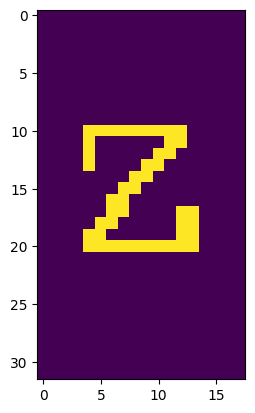

In [ ]:
from PIL import ImageDraw, ImageFont
import string
import random
import torch
import torchvision
from torchvision import transforms
from PIL import Image # PIL is a library to process images
from matplotlib import pyplot as plt

simple_transforms = transforms.Compose([
                                    transforms.ToTensor(),
                                ])

class SimpleWordsDataset(torch.utils.data.IterableDataset):

  def __init__(self, max_length, len=100, jitter=False, noise=False):
    self.max_length = max_length
    self.transforms = transforms.ToTensor()
    self.len = len
    self.jitter = jitter
    self.noise = noise

  def __len__(self):
    return self.len

  def __iter__(self):
    for _ in range(self.len):
        text = ''.join([random.choice(string.ascii_lowercase) for i in range(self.max_length)])
        img = self.draw_text(text, jitter=self.jitter, noise=self.noise)
        yield img, text

  def draw_text(self, text, length=None, jitter=False, noise=False):
    if length == None:
        length = 18 * len(text)
    img = Image.new('L', (length, 32))
    fnt = ImageFont.truetype("fonts/Anonymous.ttf", 20)

    d = ImageDraw.Draw(img)
    pos = (0, 5)
    if jitter:
        pos = (random.randint(0, 7), 5)
    else:
        pos = (0, 5)
    d.text(pos, text, fill=1, font=fnt)

    img = self.transforms(img)
    img[img > 0] = 1

    if noise:
        img += torch.bernoulli(torch.ones_like(img) * 0.1)
        img = img.clamp(0, 1)


    return img[0]

sds = SimpleWordsDataset(1, jitter=True, noise=False)
img, text = next(iter(sds))
print(img.shape)
plt.imshow(img)
print(f'image for: {text}')

We can look at what the entire alphabet looks like in this dataset.

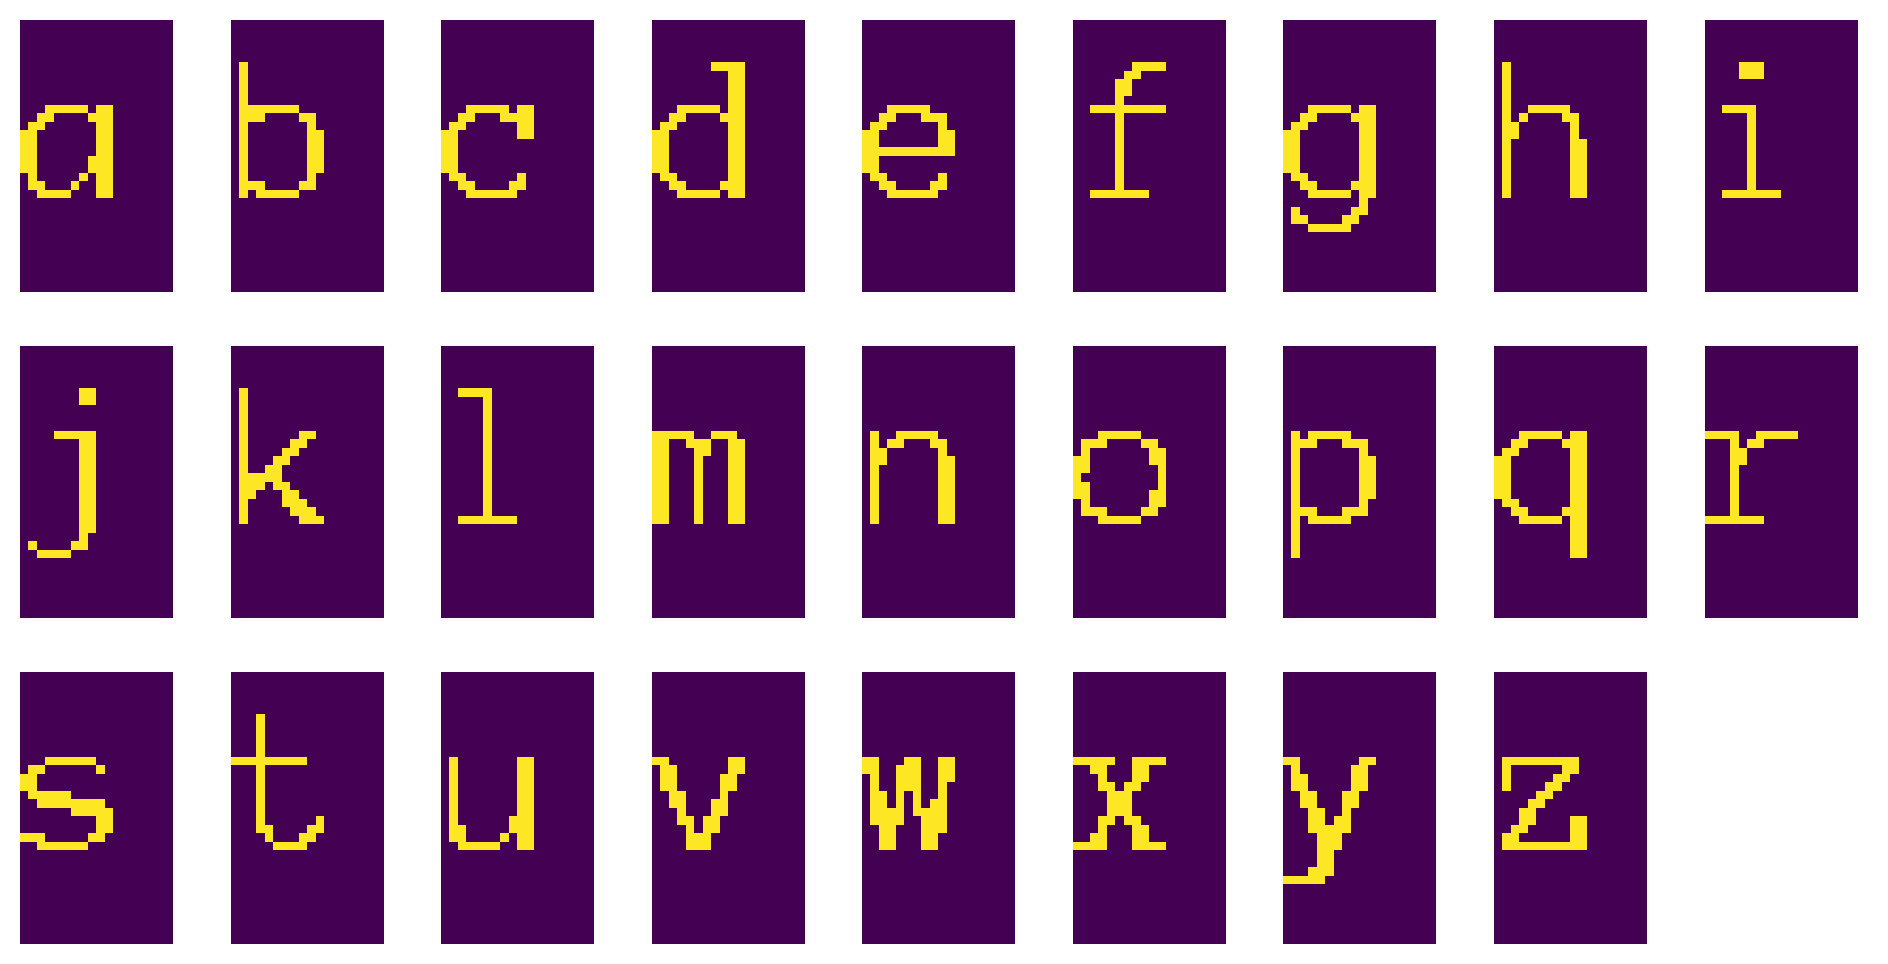

In [ ]:
fig, ax = plt.subplots(3, 9, figsize=(12, 6), dpi=200)

for i, c in enumerate(string.ascii_lowercase):
    row = i // 9
    col = i % 9
    ax[row][col].imshow(sds.draw_text(c))
    ax[row][col].axis('off')
ax[2][8].axis('off')

plt.show()

We can also put the entire alphabet in one image.

(-0.5, 339.5, 31.5, -0.5)

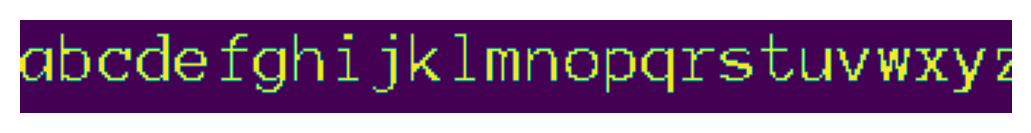

In [ ]:
alphabet = sds.draw_text(string.ascii_lowercase, 340)
plt.figure(dpi=200)
plt.imshow(alphabet)
plt.axis('off')

## Model definition
Before we define the model, we define the size of our alphabet. Our alphabet consists of lowercase English letters, and additionally a special character used for space between symbols or before and after the word. For the first part of this assignment, we don't need that extra character.

Our end goal is to learn to transcribe words of arbitrary length. However, first, we pre-train our simple convolutional neural net to recognize single characters. In order to be able to use the same model for one character and for entire words, we are going to design the model in a way that makes sure that the output size for one character (or when input image size is 32x18) is 1x27, and Kx27 whenever the input image is wider. K here will depend on particular architecture of the network, and is affected by strides, poolings, among other things.
A little bit more formally, our model $f_\theta$, for an input image $x$ gives output energies $l = f_\theta(x)$. If $x \in \mathbb{R}^{32 \times 18}$, then $l \in \mathbb{R}^{1 \times 27}$.
If $x \in \mathbb{R}^{32 \times 100}$ for example, our model may output $l \in \mathbb{R}^{10 \times 27}$, where $l_i$ corresponds to a particular window in $x$, for example from $x_{0, 9i}$ to $x_{32, 9i + 18}$ (again, this will depend on the particular architecture).

Below is a drawing that explains the sliding window concept. We use the same neural net with the same weights to get $l_1, l_2, l_3$, the only difference is receptive field. $l_1$ is looks at the leftmost part, at character 'c', $l_2$ looks at 'a', and $l_3$ looks at 't'. The receptive field may or may not overlap, depending on how you design your convolutions.

![cat.png](https://i.imgur.com/JByfyKh.png)

In [ ]:
# constants for number of classes in total, and for the special extra character for empty space
ALPHABET_SIZE = 27
BETWEEN = 26

In [ ]:
# Import necessary modules from PyTorch
from torch import nn
import torch.nn.functional as F

# Set device to GPU if available, else fall back to CPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
#from torch import nn  # Redundant import commented out

# Define a simple neural network class inheriting from torch.nn.Module
class SimpleNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # Define window parameters for processing sliding windows over the input
        self.window_size = 10
        self.window_interval = 4

        # First convolutional layer block:
        # Applies a convolution, batch normalization, ReLU activation, and max pooling
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),  # Convolution: 1 input channel, 32 output channels, kernel size 3, padding 1
            nn.BatchNorm2d(32),              # Batch normalization for 32 channels
            nn.ReLU(),                       # ReLU activation function
            nn.MaxPool2d(2),                 # Max pooling with kernel size 2 to downsample the feature map
        )

        # Second convolutional layer block:
        # Similar structure as the first block, but increases channel depth
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1), # Convolution: 32 input channels, 64 output channels
            nn.BatchNorm2d(64),              # Batch normalization for 64 channels
            nn.ReLU(),                       # ReLU activation function
            nn.MaxPool2d(2),                 # Max pooling to further downsample the feature map
        )

        # Third convolutional layer block:
        # Contains two consecutive convolution operations with batch normalization and ReLU activation
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 64, 3, padding=1), # First convolution in this block: maintains 64 channels
            nn.BatchNorm2d(64),              # Batch normalization for 64 channels
            nn.ReLU(),                       # ReLU activation function
            nn.Conv2d(64, 64, 3, padding=1), # Second convolution in this block: maintains 64 channels
            nn.BatchNorm2d(64),              # Batch normalization for 64 channels
            nn.ReLU(),                       # ReLU activation function
        )

        # Fully connected layers (classifier)
        # The first linear layer transforms the flattened feature map into 128 units
        # The second linear layer outputs 27 classes (could be alphabet letters or similar)
        self.fc = nn.Sequential(
            nn.Linear(64 * 8 * (self.window_size // 4), 128),  # Calculate input size based on feature map dimensions
            nn.ReLU(),                                         # ReLU activation function
            nn.Linear(128, 27),                                # Final linear layer outputs 27 units
        )

    def forward(self, x):
        """
        Forward pass of the network.
        Input x: (batch_size, 1, 32, k) where k is the variable width dimension.
        The CNN blocks are applied over sliding windows of the input.
        After processing, output shape becomes: (batch_size, n_windows, 27)
        where n_windows is the number of sliding windows computed over the input.
        """
        # Calculate the number of windows based on the input width, window size, and interval
        n_windows = (x.shape[-1] - self.window_size) // self.window_interval + 1
        # Initialize an empty tensor to store outputs from each window; size: (batch_size, n_windows, 27)
        ret = torch.zeros(x.shape[0], n_windows, 27, device=device)

        # Process each sliding window separately
        for i in range(n_windows):
            # Determine the start and end indices for the current window
            start = i * self.window_interval
            end = start + self.window_size
            # Slice the input to get the current window
            temp = x[:, :, :, start:end]
            # Pass through the first convolutional block
            temp = self.layer1(temp)
            # Pass through the second convolutional block
            temp = self.layer2(temp)
            # Pass through the third convolutional block
            temp = self.layer3(temp)
            # Flatten the output tensor to be suitable for the fully connected layers
            temp = temp.view(-1, 64 * 8 * (self.window_size // 4))
            # Pass through the fully connected (classification) layers
            temp = self.fc(temp)
            # Store the output for this window in the result tensor
            ret[:, i, :] = temp

        # Return the aggregated outputs for all windows
        return ret


Let's initalize the model and apply it to the alphabet image:

In [ ]:
model = SimpleNet()

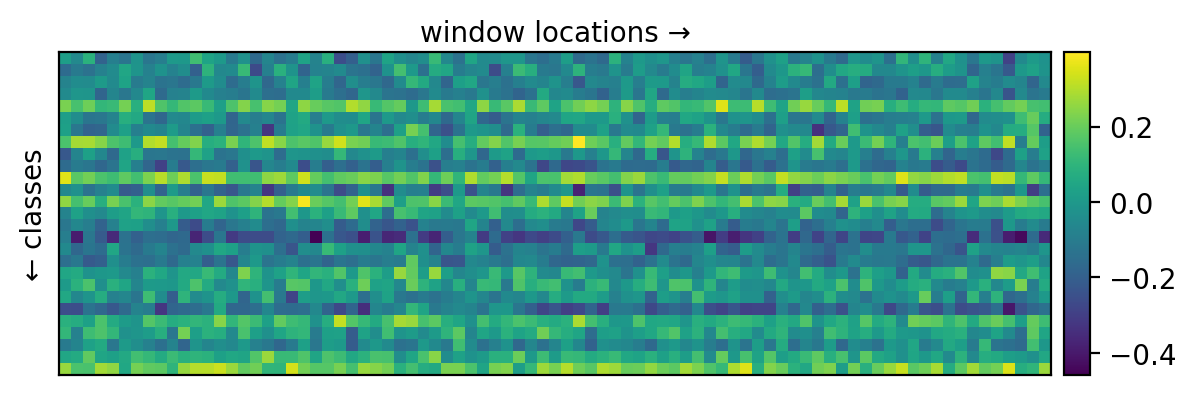

In [ ]:
alphabet_energies = model(alphabet.view(1, 1, *alphabet.shape))

def plot_energies(ce):
    fig=plt.figure(dpi=200)
    ax = plt.axes()
    im = ax.imshow(ce.cpu().T)

    ax.set_xlabel('window locations →')
    ax.set_ylabel('← classes')
    ax.xaxis.set_label_position('top')
    ax.set_xticks([])
    ax.set_yticks([])

    cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
    plt.colorbar(im, cax=cax)

plot_energies(alphabet_energies[0].detach())

So far we only see random outputs, because the classifier is untrained.

## Train with one character

Now we train the model we've created on a dataset where images contain only single characters. Note the changed cross_entropy function.

In [ ]:
def train_model(model, epochs, dataloader, criterion, optimizer):
    # Set the model to training mode
    model.train()
    for epoch in range(epochs):
        # Initialize cumulative loss and accuracy for the epoch
        running_loss = 0.0
        running_acc = 0.0

        # Create a progress bar for iterating through the dataloader
        pbar = tqdm(dataloader, total=len(dataloader))
        for img, text in pbar:
            # Move image tensor to GPU (if available)
            img = img.cuda()
            # Add an extra channel dimension to the image tensor (required by the model)
            img = img.unsqueeze(1)
            # Move text tensor to GPU (if available)
            text = text.cuda()

            # Zero the gradients before the backward pass
            optimizer.zero_grad()

            # Forward pass: compute the model output
            output = model(img)
            # Extract the energy from the first slice along the window dimension
            energy = output[:, 0, :]
            # Calculate accuracy: check if the index with minimum energy equals the target text
            acc = (energy.argmin(dim=-1) == text).float().mean()
            # Compute the loss using the provided criterion
            loss = criterion(energy, text)

            # Backward pass: compute gradients
            loss.backward()
            # Update model parameters using the optimizer
            optimizer.step()

            # Accumulate loss and accuracy for this batch
            running_loss += loss.item()
            running_acc += acc.item()

            # Update the progress bar with current epoch, loss, and accuracy
            pbar.set_postfix(epoch=epoch, loss=loss.item(), acc=acc.item())

        # Calculate average loss and accuracy for the epoch
        epoch_loss = running_loss / len(dataloader)
        epoch_acc = running_acc / len(dataloader)
        print(f'Epoch {epoch+1}, Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}')

    # Return the trained model
    return model


In [ ]:
from tqdm.notebook import tqdm
import torch.optim as optim

def cross_entropy(energies, *args, **kwargs):
    """ We use energies, and therefore we need to use log soft arg min instead
        of log soft arg max. To do that we just multiply energies by -1. """
    return nn.functional.cross_entropy(-1 * energies, *args, **kwargs)

def simple_collate_fn(samples):
    images, annotations = zip(*samples)
    images = list(images)
    annotations = list(annotations)
    annotations = list(map(lambda c : torch.tensor(ord(c) - ord('a')), annotations))
    m_width = max(18, max([i.shape[1] for i in images]))
    for i in range(len(images)):
        images[i] = torch.nn.functional.pad(images[i], (0, m_width - images[i].shape[-1]))

    if len(images) == 1:
        return images[0].unsqueeze(0), torch.stack(annotations)
    else:
        return torch.stack(images), torch.stack(annotations)

sds = SimpleWordsDataset(1, len=1000, jitter=True, noise=False)
dataloader = torch.utils.data.DataLoader(sds, batch_size=16, num_workers=0, collate_fn=simple_collate_fn)

model.cuda()
# TODO: initialize optimizer, train the model on the one-character dataset
optimizer = optim.Adam(model.parameters(), lr=0.001)
model = train_model(model, epochs=10, dataloader=dataloader, criterion=cross_entropy, optimizer=optimizer)


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch 1, Loss: 1.8979, Acc: 0.5089


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch 2, Loss: 0.3099, Acc: 0.8968


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch 3, Loss: 0.1727, Acc: 0.9286


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch 4, Loss: 0.1518, Acc: 0.9325


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5, Loss: 0.1375, Acc: 0.9385


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch 6, Loss: 0.1071, Acc: 0.9375


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch 7, Loss: 0.1349, Acc: 0.9276


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch 8, Loss: 0.1265, Acc: 0.9306


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch 9, Loss: 0.1332, Acc: 0.9325


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch 10, Loss: 0.1055, Acc: 0.9415


In [ ]:
def get_accuracy(model, dataset):
    cnt = 0
    for i, l in dataset:
        energies = model(i.unsqueeze(0).unsqueeze(0).cuda())[0, 0]
        x = energies.argmin(dim=-1)
        cnt += int(x == (ord(l[0]) - ord('a')))
    return cnt / len(dataset)

tds = SimpleWordsDataset(1, len=100)
accuracy = get_accuracy(model, tds)
print(f'accuracy: {accuracy}')
assert accuracy == 1.0, 'Your model doesn\'t achieve near perfect accuracy for 1 character'

accuracy: 1.0


Now, to see how our model would work with more than one character, we apply the model to a bigger input - the image of the alphabet we saw earlier. We extract the energies for each window and show them.

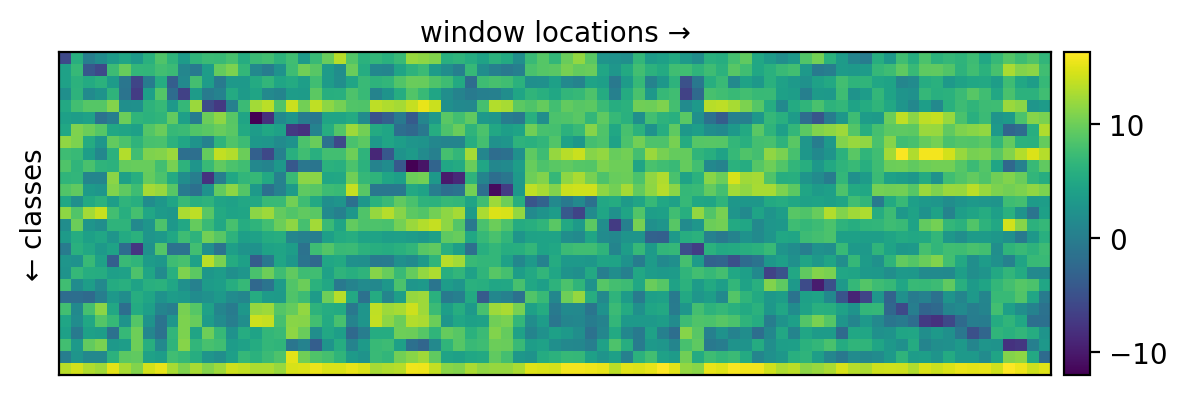

In [ ]:
alphabet_energies_post_train = model(alphabet.cuda().view(1, 1, *alphabet.shape))
plot_energies(alphabet_energies_post_train[0].detach())


Question: Explain any classes that are lit up. What is still missing to be able to use it for transcription of words?

Answer: #TODO


In the heatmap, each column corresponds to a “window” over the input image, and each row is one of the 27 classes (26 letters plus 1 extra). Darker (more negative) values indicate lower energy (higher confidence). You can see a diagonal band or several dark patches, meaning the network is strongly favoring certain classes at certain window positions. Essentially, the model has learned to recognize the presence of specific characters in those local regions.

What is still missing for word transcription:
Even though some classes show confidently low energies, there is no mechanism yet to handle character‐to‐character alignment for variable‐length words. In particular, we lack:

A separator (blank) symbol (or a special character) to distinguish between repeated letters or transitions from one letter to the next.

A dynamic alignment method that maps each window position to the correct character in a multi-character target sequence.

Without these components, the model can recognize single characters well but cannot properly segment and decode entire words.

## Training with multiple characters

Now, we want to train our model to not only recognize the letters, but also to recognize space in-between so that we can use it for transcription later.

This is where complications begin. When transcribing a word from an image, we don't know beforehand how long the word is going to be. We can use our convolutional neural network we've pretrained on single characters to get prediction of character probabilities for all the positions of an input window in the new input image, but we don't know beforehand how to match those predictions with the target label. Training with incorrect matching can lead to wrong model, so in order to be able to train a network to transcribe words, we need a way to find these pairings.

![dl.png](https://i.imgur.com/7pnodfV.png)

The importance of pairings can be demonstrated by the drawing above. If we map $l_1, l_2, l_3, l_4$ to 'c', 'a', 't', '_' respectively, we'll correctly train the system, but if we put $l_1, l_2, l_3, l_4$ with 'a', 'a', 't', 't', we'd have a very wrong classifier.

To formalize this, we use energy-based models' framework. Let's define the energy $E(x, y, z)$ as the sum of cross-entropies for a particular pairing between probabilities our model gives for input image $x$ and text transcription $y$, and pairing $z$. $z$ is a function $z : \{1, 2, \dots, \vert l \vert \} \to \{1, 2, \dots, \vert y \vert)$, $l$ here is the energies output of our convolutional neural net $l = f_\theta(x)$. $z$ maps each energy vector in $l$ to an element in the output sequence $y$. We want the mappings to make sense, so $z$ should be a non-decreasing function $z(i) \leq z(i+1)$, and it shouldn't skip characters, i.e. $\forall_i \exists_j z(j)=i$.

Energy is then $E(x, y, z) = C(z) + \sum_{i=1}^{\vert l \vert} l_i[z(i)]$
,  $C(z)$ is some extra term that allows us to penalize certain pairings, and $l_i[z(i)]$ is the energy of $z(i)$-th symbol on position $i$.

In this particular context, we define $C(z)$ to be infinity for impossible pairings:
$$C(z) = \begin{cases}
\infty \; \text{if} \; z(1) \neq 1 \vee z(\vert l \vert) \neq \vert y \vert \vee \exists_{i, 1\leq 1 \leq \vert l \vert - 1} z(i) > z(i+1) \vee z(i) < z(i+1) - 1\\
0 \; \text{otherwise}
\end{cases}
$$


Then, the free energy $F(x, y) = \arg \min_z E(x, y, z)$. In other words, the free energy is the energy of the best pairing between the probabilities provided by our model, and the target labels.

When training, we are going to use cross-entropies along the best path: $\ell(x, y, z) = \sum_{i=1}^{\vert l \vert}H(y_{z(i)}, \sigma(l_i))$, where $H$ is cross-entropy, $\sigma$ is soft-argmin needed to convert energies to a distribution.

First, let's write functions that would calculate the needed cross entropies $H(y_{z(i)}, \sigma(l_i))$, and energies for us.

In [ ]:
def build_path_matrix(energies, targets):
    # Convert energies tensor to the same device as targets (e.g., CPU or GPU)
    energies = energies.to(targets.device)

    # Get batch size, number of energy positions (L), and ignore the last dimension (27 classes)
    batch_size, L, _ = energies.shape
    # Get target length (T)
    _, T = targets.shape

    # Unsqueeze targets along the third dimension to prepare for expansion.
    # After unsqueeze, shape becomes: [batch_size, T, 1]
    targets_unsqueeze = targets.unsqueeze(2)

    # Expand targets to match the dimensions required for gathering energies.
    # First, expand to shape [batch_size, T, L], then transpose dimensions to get [batch_size, L, T]
    targets_expand = targets_unsqueeze.expand(batch_size, T, L).transpose(1, 2)

    # Gather energies from the last dimension using the indices in targets_expand.
    # For each batch and each energy position j, and for each target k, this selects:
    # energies[i, j, targets[i, k]]
    path_matrix = energies.gather(2, targets_expand)

    # Return the constructed path matrix of shape [batch_size, L, T]
    return path_matrix


def build_ce_matrix(energies, targets):
    # Get the batch size, number of energy positions (L), and target length (T)
    batch_size = energies.shape[0]
    sequence_length = energies.shape[1]
    target_length = targets.shape[1]

    # Reshape energies to a 2D tensor where each row corresponds to an energy vector of length 27.
    # Then, repeat each row target_length times along the 0-th dimension.
    # After this, energies_reshaped has shape: [batch_size * L * target_length, 27]
    energies_reshaped = torch.repeat_interleave(energies.view(-1, 27), targets.shape[-1], 0)

    # For targets, add an extra dimension so that each target vector becomes shape [1] and repeat along
    # the energy position dimension. The unsqueeze makes it [batch_size, 1, T], and then repeating along dimension 1
    # gives a shape of [batch_size, L, T]. Finally, view it as a flat vector.
    targets_repeated = torch.repeat_interleave(targets.unsqueeze(1), energies.shape[1], 1).view(-1)

    # Compute the cross-entropy loss for each pair without reducing (thus keeping individual losses)
    # The resulting tensor is then reshaped to [batch_size, sequence_length (L), target_length (T)]
    output = cross_entropy(energies_reshaped, targets_repeated, reduction='none').view(batch_size, sequence_length, target_length)
    return output


# Code to test your implementation for both functions
for _ in range(10):
    # Generate random energies tensor with shape [8, 20, ALPHABET_SIZE]
    energies = torch.randn(8, 20, ALPHABET_SIZE)
    # Generate random targets tensor with shape [8, 15] with values in the range [0, ALPHABET_SIZE)
    targets = torch.randint(ALPHABET_SIZE, (8, 15))

    # Build the path matrix using the provided function
    pm = build_path_matrix(energies, targets)

    # Randomly select indices for batch (b), energy position (i), and target (j) to test correctness
    b = random.randint(0, energies.shape[0] - 1)
    i = random.randint(0, energies.shape[1] - 1)
    j = random.randint(0, targets.shape[1] - 1)

    # Assert that the path matrix value at [b, i, j] matches the energy at the index specified by targets[b, j]
    assert pm[b, i, j] == energies[b, i, targets[b, j]]

    # Build the cross-entropy matrix using the provided function
    ce = build_ce_matrix(energies, targets)

    # Assert that the computed cross-entropy loss for the selected indices matches the cross_entropy
    # computed individually for energies[b, i] and target targets[b, j].
    assert ce[b, i, j] == cross_entropy(energies[b, i].unsqueeze(0),
                                        targets[b, j].to(energies.device).unsqueeze(0))


Another thing we will need is a transformation for our label $y$. We don't want to use it as is, we want to insert some special label after each character, so, for example 'cat' becomes 'c_a_t_'. This extra '\_' models the separation between characters, allowing our model to distinguish between strings 'aa' and 'a' in its output. This is then used in inference - we can just get the most likely character for each position from $l = f_\theta(x)$ (for example 'aa_bb_ccc_'), and then remove duplicate characters ('a_b_c_'), and then remove _ (abc).
Let's implement a function that would change the string in this manner, and then map all characters to values from 0 to 26, with 0 to 25 corresponding to a-z, and 26 corresponding to _:

In [ ]:
def transform_word(s):
    # This function converts a string 's' into a tensor.
    # For each character in the string, it computes the 0-indexed position in the alphabet,
    # and then appends a separator token (26) right after.
    # The resulting tensor has a length of 2 * len(s).

    l = []  # Initialize an empty list to store the computed values.
    for i in s:
        # Calculate the 0-indexed position of the character in the alphabet.
        l.append(ord(i) - ord('a'))
        # Append the separator token (26) after the character's index.
        l.append(26)
    # Convert the list to a PyTorch tensor.
    l = torch.tensor(l)
    return l


Now, let's plot energy table built on our model's prediction for alphabet image.

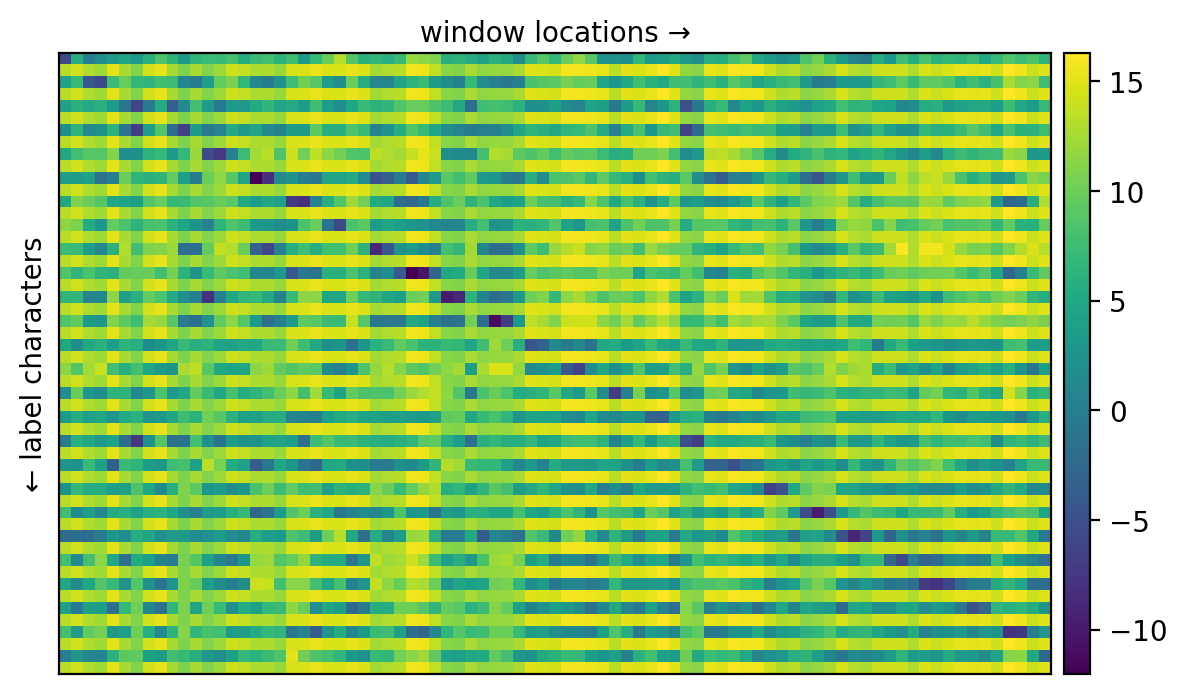

In [ ]:
def plot_pm(pm, path=None):
    fig=plt.figure(dpi=200)
    ax = plt.axes()
    im = ax.imshow(pm.cpu().T)

    ax.set_xlabel('window locations →')
    ax.set_ylabel('← label characters')
    ax.xaxis.set_label_position('top')
    ax.set_xticks([])
    ax.set_yticks([])

    if path is not None:
        for i in range(len(path) - 1):
            ax.plot(*path[i], *path[i+1], marker = 'o', markersize=0.5, linewidth=10, color='r', alpha=1)

    cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
    plt.colorbar(im, cax=cax)

energies = model(alphabet.cuda().view(1, 1, *alphabet.shape)) # [1, k, 27]
targets = transform_word(string.ascii_lowercase).unsqueeze(0).cuda() # [1, 26 * 2]

pm = build_path_matrix(energies, targets)
plot_pm(pm[0].detach())

Question: What do you see? What does the model classify correctly, and what does it have problems with?

Answer: #TODO

What the heatmap shows:

Each row corresponds to a character in the transformed target label (including the special separator/blank), and each column is a position (window) in the input image.

The color scale represents energy or cost values (lower = darker = more confident).

You can see that some rows (characters) have consistently lower energies in specific column ranges, indicating the model is fairly confident about matching those characters in those regions.

What the model classifies correctly:

Certain characters show clear dark (low-energy) streaks along a diagonal or a band, suggesting the model can reliably detect those characters at the right positions.

For simpler or more distinct letters, the alignment is more obvious, and the model’s energies form a coherent “path” through the matrix.

What it has problems with:

Confusions around separators (or blank tokens): The model may have trouble separating consecutive characters or handling repeated letters if the separator energy is not distinctly lower in the right places.

Ambiguous characters: Some letters that look similar (e.g., ‘c’ vs. ‘e’, or letters with similar shapes) may produce noisy/confused regions.

Alignment drift: The “dark path” might shift in places, meaning the model is uncertain about which window should map to which character, especially if characters are close together or blurred.

Overall, while the model is getting some letters right, you can still see stretches of uncertainty or incorrect alignment—underscoring the need for a proper dynamic alignment or path search (Viterbi/CTC) to handle full word transcription accurately.

Question: Searching for a good pairing $z$ is same as searching for a trajectory with a small sum of it's values in this `pm` matrix. Where does the trajectory start, and where does it end? What other properties does the trajectory have? Can you see where an optimal trajecotry would be passing through in the plot above?

Answer: #TODO

Where the trajectory starts and ends:

The trajectory begins at the top‐left cell
(
0
,
0
)
(0,0) in the path matrix (i.e., the first window position and the first target character).

It ends at the bottom‐right cell
(
𝐿
−
1
,

𝑇
−
1
)
(L−1,T−1) (i.e., the last window position and the last target character).

Other properties of the trajectory:

Monotonic movement: You can only move downward (to the next window) or diagonally (to the next window and the next character). This enforces a non‐decreasing alignment from left to right, matching the temporal ordering of characters.

No skipping of target characters: Each character in the target must appear at least once along the path, so the path must visit every target character in order.

Minimizing total cost (energy): The optimal path is the one that yields the smallest cumulative sum of the matrix values (i.e., the best alignment).

Where the optimal trajectory appears in the plot:

In the plot, you typically see a “dark” (low‐energy) band or a path that moves roughly diagonally from top‐left to bottom‐right. That dark band corresponds to the model’s strongest alignment between each window and the correct character. The Viterbi or DP algorithm will choose the path of these low‐energy cells that best matches the target sequence.

Now let's implement a function that would tell us the energy of a particular path (i.e. pairing).

In [ ]:
def path_energy(pm, path):
    # Calculate the total energy along a given path through the energy matrix.
    # Inputs:
    #   pm - a matrix of energies with shape (L, T)
    #         L: number of energy vectors (length of energies)
    #         T: number of target classes (each energy vector has T elements)
    #   path - a list of length L where each element is an index mapping the energy vector
    #          at that row to one of the T target classes.
    # Returns:
    #   The sum of energies along the specified path if all indices are valid,
    #   otherwise returns 2**30 as a penalty for an invalid mapping.

    # Initialize the energy accumulator to zero.
    energy = 0
    # Unpack the shape of the energy matrix into L (number of rows) and T (number of columns).
    L, T = pm.shape

    # Iterate over each energy vector (row) in the matrix.
    for l in range(L):
        # Check if the current path index is out of valid range [0, T).
        if path[l] < 0 or path[l] >= T:
            # Return a high penalty energy if the index is invalid.
            return 2**30
        # Accumulate the energy corresponding to the current mapping:
        # pm[l, path[l]] gives the energy at row l for the target index specified in the path.
        energy += pm[l, path[l]]

    # Return the total accumulated energy along the path.
    return energy


Now we can check some randomly generated paths and see the associated energies for our alphabet image:

energy is 735.5462646484375


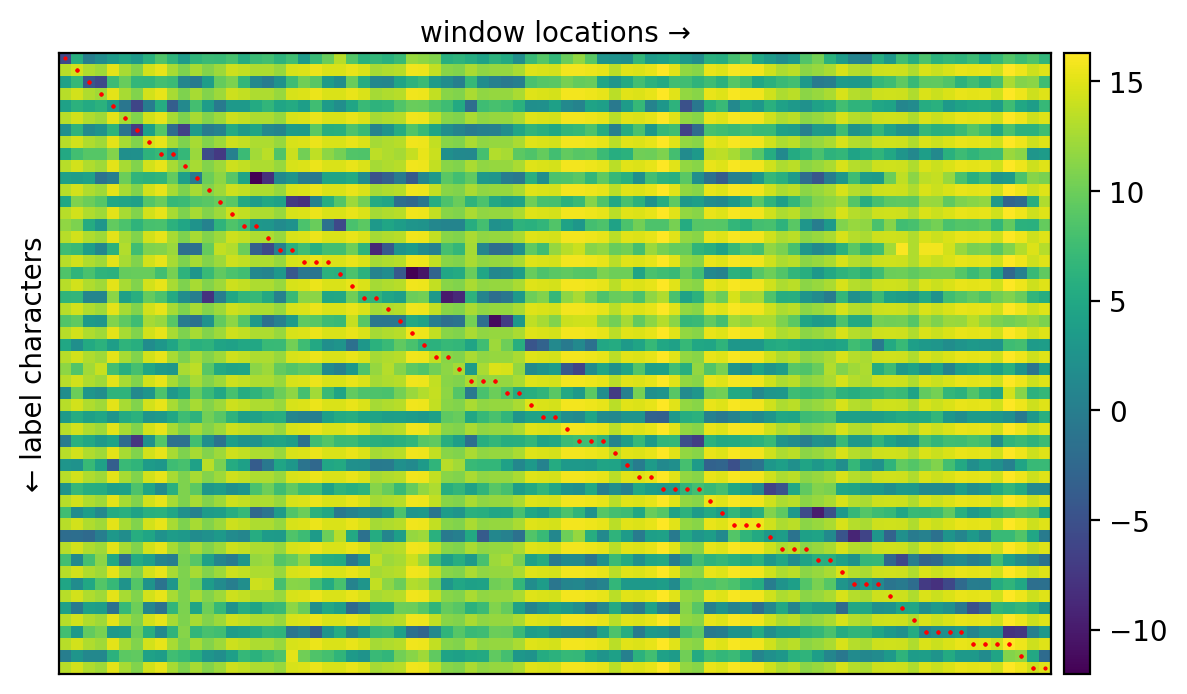

In [ ]:
path = torch.zeros(energies.shape[1] - 1) # [L - 1]
path[:targets.shape[1] - 1] = 1
path = [0] + list(map(lambda x : x.int().item(), path[torch.randperm(path.shape[0])].cumsum(dim=-1)))
points = list(zip(range(energies.shape[1]), path))

plot_pm(pm[0].detach(), points)
print('energy is', path_energy(pm[0], path).item())

## Part - 1\: Viterbi

### Optimal path finding
Now, we're going to implement the finding of the optimal path. To do that, we're going to use Viterbi algorithm, which in this case is a simple dynamic programming problem.
In this context, it's a simple dynamic programming algorithm that for each pair i, j, calculates the minimum cost of the path that goes from 0-th index in the energies and 0-th index in the target, to i-th index in the energies, and j-th index in the target. We can memorize the values in a 2-dimensional array, let's call it `dp`. Then we have the following transitions:
```
dp[0, 0] = pm[0, 0]
dp[i, j] = min(dp[i - 1, j], dp[i - 1, j - 1]) + pm[i, j]
```

The optimal path can be recovered if we memorize which cell we came from for each `dp[i, j]`.

Below, you'll need to implement this algorithm:

In [ ]:
def find_path(pm):
    # pm: tensor of shape (L, T) representing the energy matrix.
    # L: number of energy positions (rows)
    # T: number of target positions (columns)
    # Returns:
    #   free_energy_tensor: the sum of energies along the best (minimum energy) path,
    #   path: a list of tuples indicating the coordinates of the best path in pm,
    #   dp: the dynamic programming array containing the cumulative energies.

    # Get the dimensions of the energy matrix.
    L, T = pm.shape
    # Initialize a dp table with the same shape as pm filled with infinity.
    dp = torch.full((L, T), float('inf'))
    # Set the starting point at the top-left corner with the corresponding energy.
    dp[0, 0] = pm[0, 0]
    # Initialize a backtracking table to record decisions, filled with -1.
    backtrack = torch.full((L, T), -1, dtype=torch.long)

    # Fill the dp table by iterating over the matrix starting from row 1 and column 1.
    for i in range(1, L):
        for j in range(1, T):
            # Compare the energy of the two possible previous positions:
            # 1. Directly above (same column, i-1, j)
            # 2. Diagonally above and to the left (i-1, j-1)
            if dp[i - 1, j] < dp[i - 1, j - 1]:
                # If moving vertically gives lower energy, choose that path.
                dp[i, j] = dp[i - 1, j] + pm[i, j]
                # Record that we came from the same column.
                backtrack[i, j] = j
            else:
                # Otherwise, choose the diagonal path.
                dp[i, j] = dp[i - 1, j - 1] + pm[i, j]
                # Record that we came from column j-1.
                backtrack[i, j] = j - 1

    # Initialize the path reconstruction starting from the bottom-right corner.
    path = [(L - 1, T - 1)]
    i, j = L - 1, T - 1
    # Backtrack until reaching the first row or first column.
    while i > 0 and j > 0:
        # Use the backtracking table to update the column index.
        j = backtrack[i, j]
        # Move up one row.
        i -= 1
        # Append the current coordinate to the path.
        path.append((i, j))

    # Reverse the path so that it starts from the top-left corner.
    path.reverse()

    # The best path energy is the value in the bottom-right cell of the dp table.
    free_energy_tensor = dp[L - 1, T - 1]

    # Return the total energy of the best path, the best path coordinates, and the dp table.
    return free_energy_tensor, path, dp


Let's take a look at the best path:

free energy is 77.4837875366211


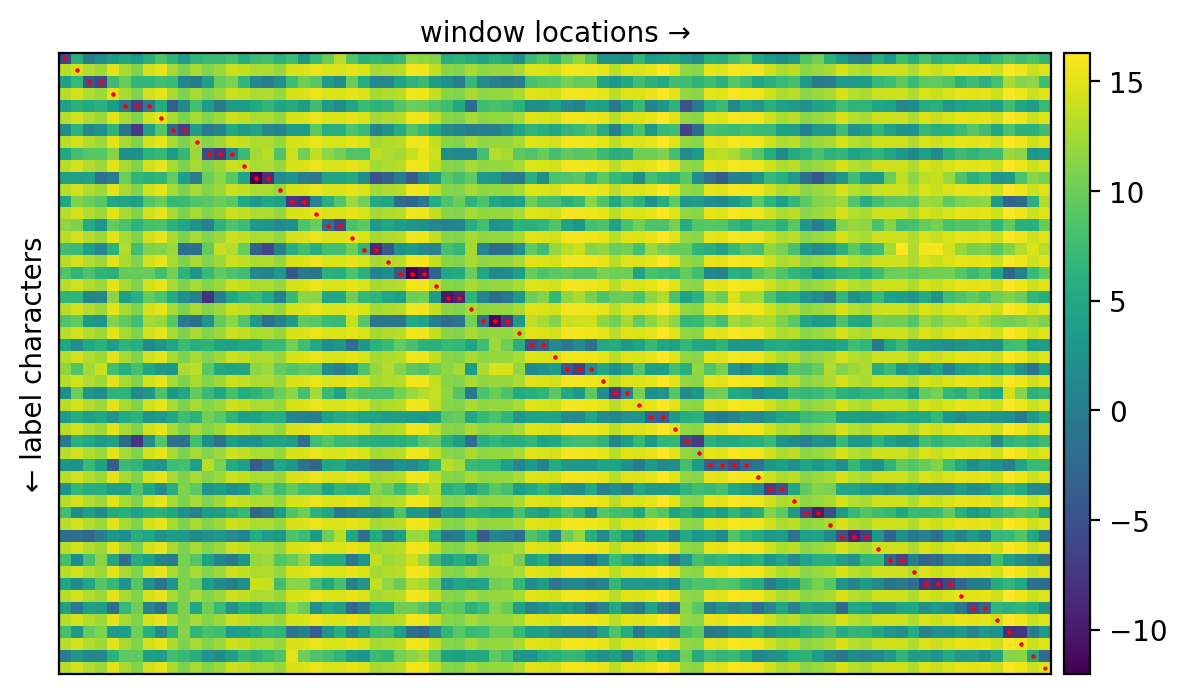

In [ ]:
free_energy, path, d = find_path(pm[0])
plot_pm(pm[0].detach(), path)
print('free energy is', free_energy.item())

We can also visualize the dp array. You may need to tune clamping to see what it looks like.

(-0.5, 82.5, 51.5, -0.5)

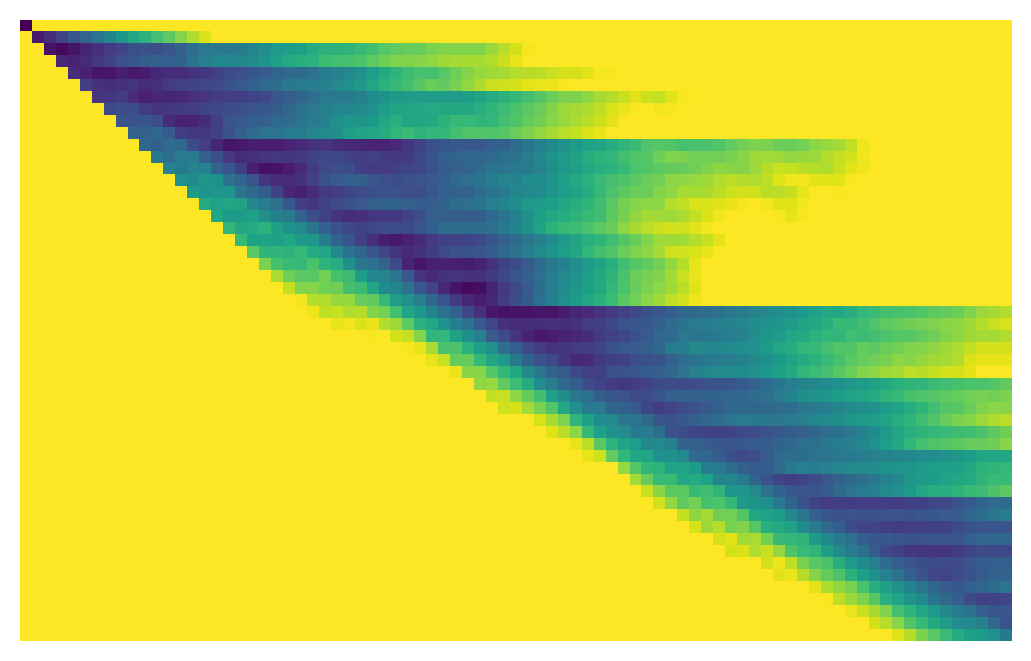

In [ ]:
plt.figure(dpi=200)
plt.imshow(d.cpu().detach().T.clamp(torch.min(d).item(), 200))
plt.axis('off')

### Training loop
Now is time to train the network using our best path finder. We're going to use the energy loss function:
$$\ell(x, y) = \sum_i H(y_{z(i)}, l_i)$$
Where $z$ is the best path we've found. This is akin to pushing down on the free energy $F(x, y)$, while pushing up everywhere else by nature of cross-entropy.

In [ ]:
def path_cross_entropy(ce, path):
    """
    Compute the total cross entropy along the best (optimal) path.

    Parameters:
      ce (Tensor or array-like): A matrix of cross entropy values with shape (L, T),
                                 where L is the number of energy steps and T is the number of targets.
      path (list of tuples): A list of length L where each element is a tuple (l, t) representing
                             the indices along the optimal path.

    Returns:
      total_ce (float or Tensor): The total cross entropy accumulated along the optimal path.
    """
    # Initialize the total cross entropy accumulator to 0.0.
    total_ce = 0.0
    # Iterate through each coordinate (l, t) in the optimal path.
    for (l, t) in path:
        # Add the cross entropy value at the current position in the ce matrix to total_ce.
        total_ce += ce[l, t]
    # Return the accumulated total cross entropy along the path.
    return total_ce


In [ ]:
def train_ebm_model(model, num_epochs, train_loader, criterion, optimizer):
    '''
    Train an Energy-Based Model (EBM) using the find_path() method.

    This function processes each batch from the train_loader, computes the energy matrices,
    builds the corresponding path and cross entropy matrices, finds the optimal path via find_path(),
    and then uses path_cross_entropy() to compute the loss which is backpropagated.
    '''
    # Create a progress bar for the total number of epochs.
    pbar = tqdm(range(num_epochs))
    # Initialize a variable to accumulate total training loss across batches.
    total_train_loss = 0.0
    # Lists to store free energies and optimal paths from each batch (for monitoring or debugging).
    free_energies = []
    paths = []
    # Set the model to training mode.
    model.train()

    # Loop over epochs using the progress bar.
    for epoch in pbar:
        # Record the start time of the epoch.
        start_time = time.time()
        # Iterate over each batch in the training data loader.
        for batch_data in train_loader:
            # Unpack the batch data into images and labels.
            images, labels = batch_data
            # Move images and labels to the GPU if available.
            images, labels = images.cuda(), labels.cuda()

            # Ensure images have a channel dimension (required by the model).
            images = images.unsqueeze(1)
            # Pass the images through the model to obtain the energy matrices.
            energy_matrices = model(images)

            # Build the path matrices from the energy matrices and corresponding labels.
            path_matrices = build_path_matrix(energy_matrices, labels)
            # Build the cross entropy matrices from the energy matrices and corresponding labels.
            cross_entropy_matrices = build_ce_matrix(energy_matrices, labels)

            # Initialize the batch loss as a tensor on the GPU.
            batch_loss = torch.tensor(0.0).cuda()
            # Process each example in the batch individually.
            for path_matrix, cross_entropy_matrix in zip(path_matrices, cross_entropy_matrices):
                # Find the optimal path for the current energy matrix using dynamic programming.
                path_free_energy, optimal_path, _ = find_path(path_matrix)
                # Store the free energy and optimal path for later analysis.
                free_energies.append(path_free_energy)
                paths.append(optimal_path)
                # Compute and accumulate the cross entropy loss along the optimal path.
                batch_loss += path_cross_entropy(cross_entropy_matrix, optimal_path)

            # Accumulate the batch loss into the total training loss.
            total_train_loss += batch_loss.item()

            # Zero out the gradients before the backward pass.
            optimizer.zero_grad()
            # Backpropagate the loss to compute gradients.
            batch_loss.backward()
            # Update the model parameters based on the computed gradients.
            optimizer.step()

        # Compute the elapsed time for the epoch.
        epoch_time = time.time() - start_time
        # Update the progress bar with the average training loss for the epoch and the epoch time.
        pbar.set_postfix({'train_loss': total_train_loss / len(train_loader), 'Epoch Time': epoch_time})

    # The function does not return a value; training updates are performed in-place.
    return


In [ ]:
import copy
import time

def collate_fn(samples):
    """ A function to collate samples into batches for multi-character case"""
    images, annotations = zip(*samples)
    images = list(images)
    annotations = list(annotations)
    annotations = list(map(transform_word, annotations))
    m_width = max(18, max([i.shape[1] for i in images]))
    m_length = max(3, max([s.shape[0] for s in annotations]))
    for i in range(len(images)):
        images[i] = torch.nn.functional.pad(images[i], (0, m_width - images[i].shape[-1]))
        annotations[i] = torch.nn.functional.pad(annotations[i], (0, m_length - annotations[i].shape[0]), value=BETWEEN)
    if len(images) == 1:
        return images[0].unsqueeze(0), torch.stack(annotations)
    else:
        return torch.stack(images), torch.stack(annotations)

sds = SimpleWordsDataset(2, 2500) # for simplicity, we're training only on words of length two

BATCH_SIZE = 32
dataloader = torch.utils.data.DataLoader(sds, batch_size=BATCH_SIZE, num_workers=0, collate_fn=collate_fn)

# TODO: 1. Create SimpleNet() model
#          To simplify the task, you can initialize the model with
#          the weights of single-character model. That would incur a 5 points
#          penalty though.
#       2. Initialize optimizer
#       3. Train the model
# note: remember that our best path finding algorithm is not batched, so you'll
# need a for loop to do loss calculation.
# This is not ideal, as for loops are very slow, but for
# demonstration purposes it will suffice. In practice, this will be
# unusable for any real problem unless it handles batching.
# also: remember that the loss is the sum of cross_entropies along the path, not
# energies!
ebm_model = copy.deepcopy(model).to(device)
optimizer_ebm = torch.optim.Adam(ebm_model.parameters(), lr=0.001)
train_ebm_model(ebm_model, 5, dataloader, build_ce_matrix, optimizer_ebm)


  0%|          | 0/5 [00:00<?, ?it/s]

Let's check what the energy matrix looks like for the alphabet image now.

free energy is -282.7193908691406


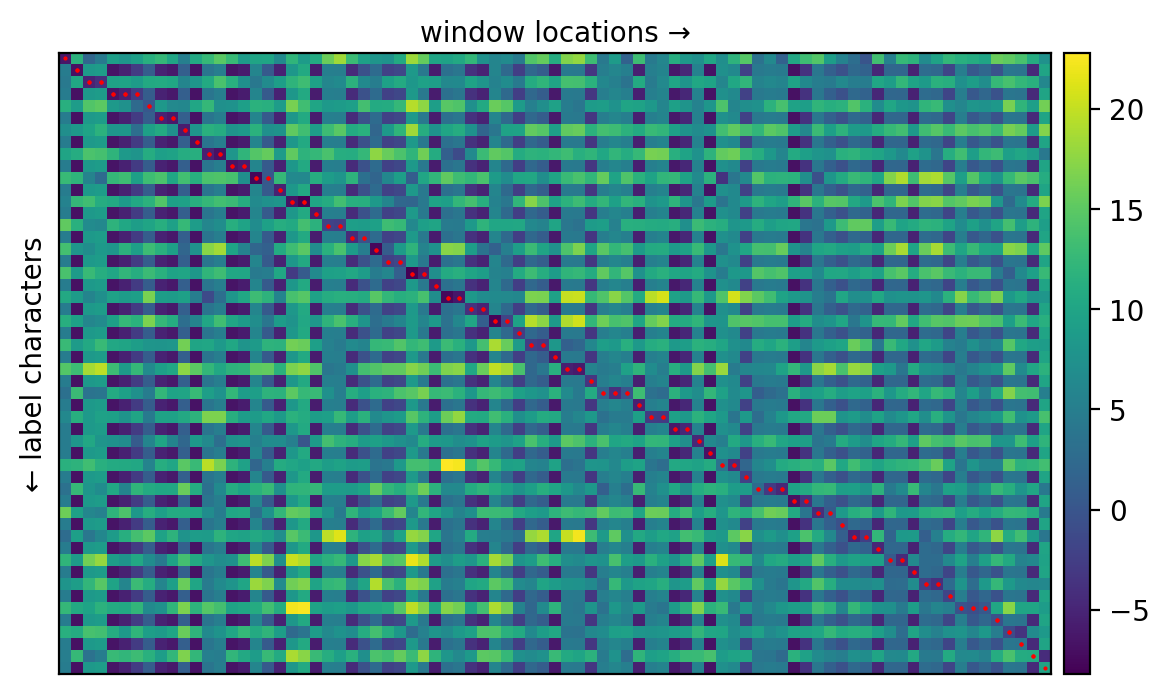

In [ ]:
energies = ebm_model(alphabet.unsqueeze(0).unsqueeze(0).cuda())
targets = transform_word(string.ascii_lowercase).cuda()
pm = build_path_matrix(energies, targets.unsqueeze(0))

free_energy, path, _ = find_path(pm[0])
plot_pm(pm[0].detach(), path)
print('free energy is', free_energy.item())

Question: Explain how the free energy changed, and why.

Answer: #TODO
How the free energy changed:
After training on multi‐character data using Viterbi alignment, the free energy (i.e., the cumulative energy along the best path) dropped significantly—often going from a positive or higher value down to a much lower (possibly negative) value.

Why it changed:

Improved Alignment: Training forces the model to produce lower energies for correct alignments, so the optimal path through the matrix becomes cheaper.

Character Separation: Including the special blank/separator and forcing correct transitions helps the network learn where each character should appear, further reducing misalignment penalties.

Refined Weights: Each update pushes the model weights so that the true path (matching the ground‐truth word) consistently gets lower energy, thereby lowering the overall free energy associated with the correct transcription.

We can also look at raw energies output:

(-0.5, 82.5, 26.5, -0.5)

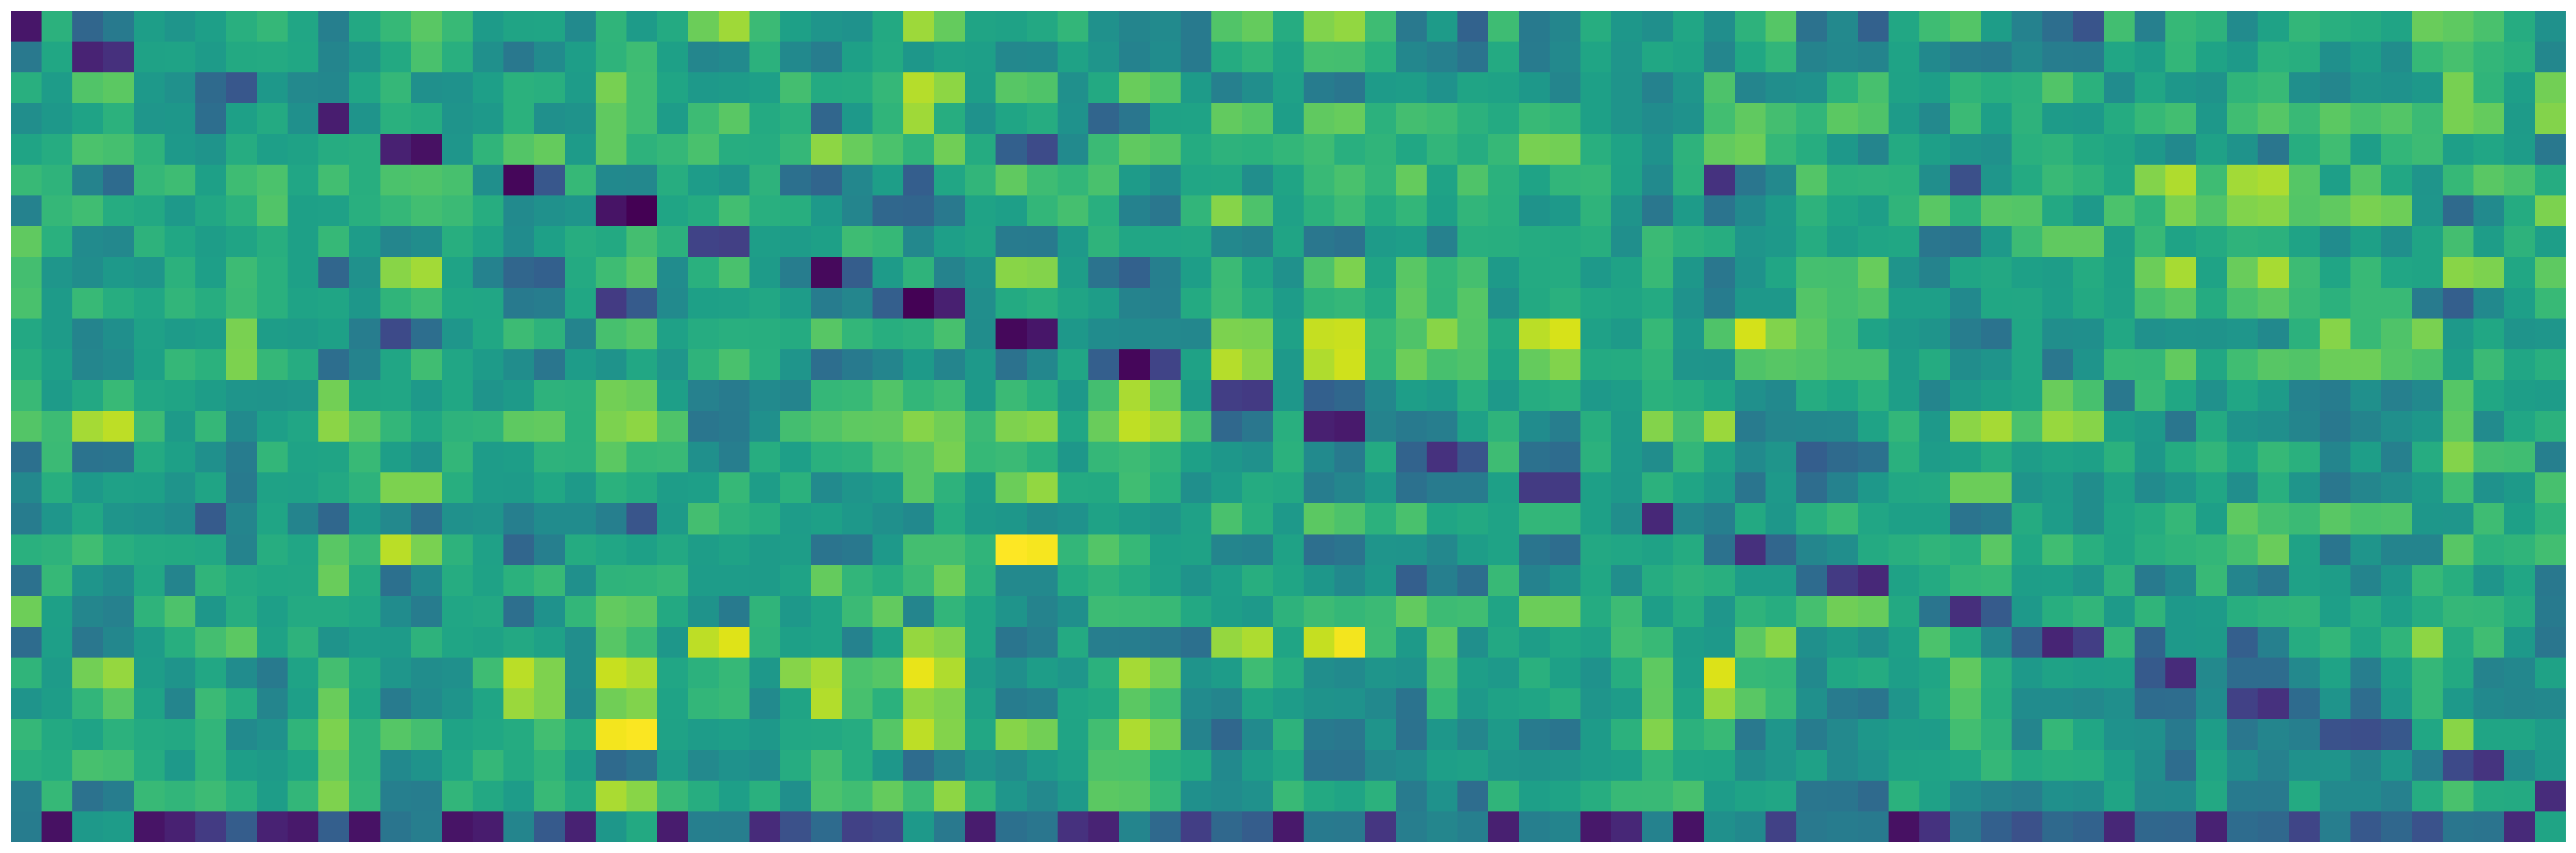

In [ ]:
alphabet_energy_post_train_viterbi = ebm_model(alphabet.cuda().view(1, 1, *alphabet.shape))

plt.figure(dpi=200, figsize=(40, 10))
plt.imshow(alphabet_energy_post_train_viterbi.cpu().data[0].T)
plt.axis('off')

Question: How does this compare to the energies we had after training only on one-character dataset?

Answer: #TODO

Comparison to single‐character training outputs:

Clearer alignment: After multi‐character training (with Viterbi alignment), you typically see a more pronounced diagonal band of low energies. This indicates the model has learned to map consecutive windows to consecutive characters more coherently.

Better separation of classes: In the single‐character‐only training, the model never learned how to align multiple characters within a single image, so its energy map for multi‐character images looked disorganized. Now, the network has lower (darker) energies where correct characters appear and higher energies elsewhere.

Lower free energy: The free energy along the correct path is noticeably lower compared to the untrained or single‐character case, reflecting that the model is now better tuned to produce minimal energy for the correct word alignment.

## Decoding

Now we can use the model for decoding a word from an image. Let's pick some word, apply the model to it, and see energies.

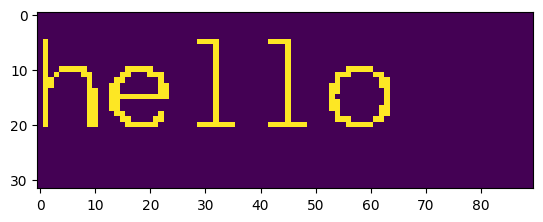

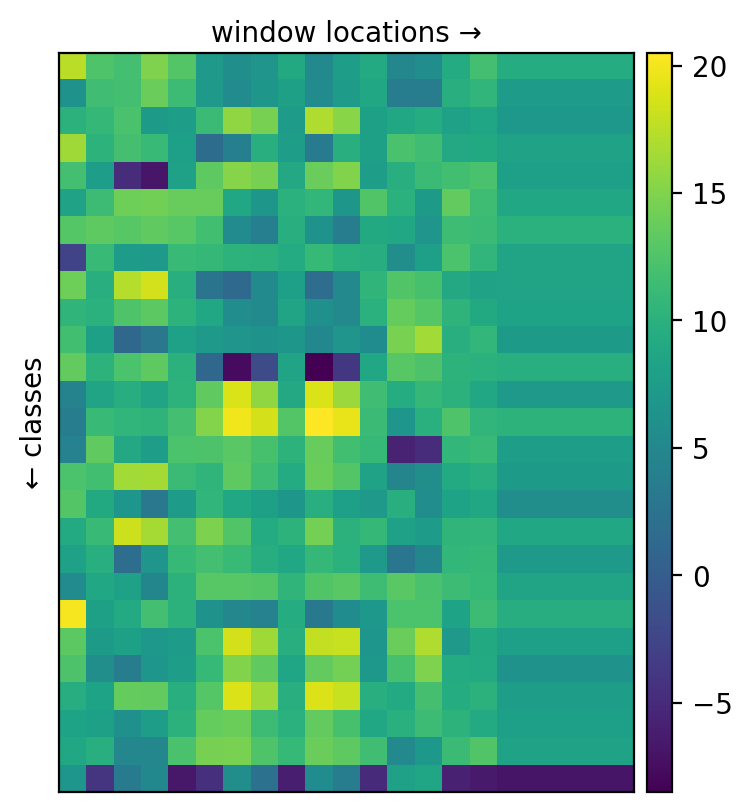

In [ ]:
img = sds.draw_text('hello')
energies = ebm_model(img.cuda().unsqueeze(0).unsqueeze(0))
plt.imshow(img)
plot_energies(energies[0].detach().cpu())

You should see some characters light up. Now, let's implement a simple decoding algorithm. To decode, first we want to get most likely classes for all energies, and then do two things:
1. segment strings using the divisors (our special character with index 26), and for each segment replace it with the most common character in that segment. Example: aaab_bab_ -> a_b. If some characters are equally common, you can pick random.
2. remove all special divisor characters: a_b -> ab


In [ ]:
from collections import Counter

def indices_to_str(indices):
    # inputs: indices - a tensor of most likely class indices
    # outputs: decoded string

    # TODO
    indices_list = indices.detach().cpu().numpy().tolist()
    characters = [chr(i + ord('a')) if i != ord('{') - ord('a') else '{' for i in indices_list]
    segments = ''.join(characters).split('{')
    result = ''.join(Counter(segment).most_common(1)[0][0] for segment in segments if segment)

    return result


min_indices = energies[0].argmin(dim=-1)
print(indices_to_str(min_indices))

hello


## Part - 2\: GTN (Extra Credits, 10pts)

### CTC Loss Function

The below cell has the CTC Loss implementation which will be needed for the training. It also has the viterbi implemented, so feel free to use it.

- For calculating loss, `CTCLoss()` can be used.
- For viterbi, `CTCLossFunction.viterbi()` can be used.

### Brief Explanation\:

GTN constructs 2 graphs-
1. Alignment graph $A_y$ that can produce a sequence of any length which when collapsed gives the output.
2. Emission graph $\mathcal{E}$ that can produce any sequence of length `L`, input's length. This can be considered as some sort of restriction over $A_y$.

Loss function is then calculated as $-\log P(y \mid X) = -(\log (A_y \circ \mathcal{E}) - \log \mathcal{E})$ where $\circ$ is the composition function.

In [ ]:
!pip install gtn==0.0.0

In [ ]:
import gtn


In [ ]:
# Credits: Adapted from https://github.com/facebookresearch/gtn_applications

class CTCLossFunction(torch.autograd.Function):
    @staticmethod
    def create_ctc_graph(target, blank_idx):
        g_criterion = gtn.Graph(False)
        L = len(target)
        S = 2 * L + 1
        for l in range(S):
            idx = (l - 1) // 2
            g_criterion.add_node(l == 0, l == S - 1 or l == S - 2)
            label = target[idx] if l % 2 else blank_idx
            g_criterion.add_arc(l, l, label)
            if l > 0:
                g_criterion.add_arc(l - 1, l, label)
            if l % 2 and l > 1 and label != target[idx - 1]:
                g_criterion.add_arc(l - 2, l, label)
        g_criterion.arc_sort(False)
        return g_criterion

    @staticmethod
    def forward(ctx, log_probs, targets, blank_idx=0, reduction="none"):
        B, T, C = log_probs.shape
        losses = [None] * B
        scales = [None] * B
        emissions_graphs = [None] * B

        def process(b):
            # create emission graph
            g_emissions = gtn.linear_graph(T, C, log_probs.requires_grad)
            cpu_data = log_probs[b].cpu().contiguous()
            g_emissions.set_weights(cpu_data.data_ptr())

            # create criterion graph
            g_criterion = CTCLossFunction.create_ctc_graph(targets[b], blank_idx)
            # compose the graphs
            g_loss = gtn.negate(
                gtn.forward_score(gtn.intersect(g_emissions, g_criterion))
            )

            scale = 1.0
            if reduction == "mean":
                L = len(targets[b])
                scale = 1.0 / L if L > 0 else scale
            elif reduction != "none":
                raise ValueError("invalid value for reduction '" + str(reduction) + "'")

            # Save for backward:
            losses[b] = g_loss
            scales[b] = scale
            emissions_graphs[b] = g_emissions

        gtn.parallel_for(process, range(B))

        ctx.auxiliary_data = (losses, scales, emissions_graphs, log_probs.shape)
        loss = torch.tensor([losses[b].item() * scales[b] for b in range(B)])
        return torch.mean(loss.cuda() if log_probs.is_cuda else loss)

    @staticmethod
    def backward(ctx, grad_output):
        losses, scales, emissions_graphs, in_shape = ctx.auxiliary_data
        B, T, C = in_shape
        input_grad = torch.empty((B, T, C))

        def process(b):
            gtn.backward(losses[b], False)
            emissions = emissions_graphs[b]
            grad = emissions.grad().weights_to_numpy()
            input_grad[b] = torch.from_numpy(grad).view(1, T, C) * scales[b]

        gtn.parallel_for(process, range(B))

        if grad_output.is_cuda:
            input_grad = input_grad.cuda()
        input_grad *= grad_output / B

        return (
            input_grad,
            None,  # targets
            None,  # blank_idx
            None,  # reduction
        )

def viterbi(energies, targets, blank_idx=0):
    outputs = -1 * energies
    B, T, C = outputs.shape
    paths = [None] * B
    scores = [None] * B
    emissions_graphs = [None] * B
    def process(b):
        L = len(targets[b])
        # create emission graph
        g_emissions = gtn.linear_graph(T, C, outputs.requires_grad)
        cpu_data = outputs[b].cpu().contiguous()
        g_emissions.set_weights(cpu_data.data_ptr())

        # create criterion graph
        g_criterion = CTCLossFunction.create_ctc_graph(targets[b], blank_idx)
        g_score = gtn.viterbi_score(gtn.intersect(g_emissions, g_criterion))
        g_path = gtn.viterbi_path(gtn.intersect(g_emissions, g_criterion))
        paths[b] = [2*p if 2*p < L else i for i, p in enumerate(g_path.labels_to_list())]
        l = 0
        paths[b] = []
        for p in g_path.labels_to_list():
            if 2*p < L:
                l = p
                paths[b].append(2*p)
            else:
                paths[b].append(2*l + 1)
        scores[b] = -1 * g_score.item()
        emissions_graphs[b] = g_emissions

    gtn.parallel_for(process, range(B))

    return (scores, paths)

CTCLoss = CTCLossFunction.apply

In [ ]:
def train_gtn_model(model, num_epochs, train_loader, criterion, optimizer):
    ''' Train CTC Model using GTN'''
    pbar = tqdm(range(num_epochs))
    train_losses = []
    total_train_loss = 0.0
    size = 0
    free_energies = []
    paths = []
    max_grad_norm = None
    if torch.cuda.is_available():
        model = model.cuda()
        device = torch.device("cuda:0")
    else:
        device = torch.device("cpu")
    for epoch in pbar:
        # TODO: implement the training loop

        epoch_time = time.time() - start_time
        train_losses.append(total_train_loss)
        pbar.set_postfix({'train_loss': total_train_loss, 'Epoch Time': epoch_time})

    return

In [ ]:
# Similar to what we have done earlier but instead of find_path(), we will use
# GTN's framework.
sds = SimpleWordsDataset(3, 2500) # for simplicity, we're training only on words of length three

BATCH_SIZE = 32
dataloader = torch.utils.data.DataLoader(sds, batch_size=BATCH_SIZE, num_workers=0, collate_fn=collate_fn)

# TODO: 1. Make another copy of the single character model and initialize optimizer
# TODO: 2. Train the model
# TODO: 1. Create SimpleNet() model
#          To simplify the task, you can initialize the model with
#          the weights of single-character model. That would incur a 5 points
#          penalty though.
#       2. Initialize optimizer
#       3. Train the model
# also: remember that the loss is the sum of cross_entropies along the path, not
# energies!




Question: Which one of the training methods\: `train_ebm_model()`, `train_gtn_model()` is faster? Why do you think so?

Answer: #TODO


In [ ]:
energies = gtn_model(alphabet.unsqueeze(0).unsqueeze(0).cuda())
targets = transform_word(string.ascii_lowercase).cuda()
pm = build_path_matrix(energies, targets.unsqueeze(0))

# TODO: Use the provided viterbi function to get score and path


# path is obtained from the above TODO
points = list(zip(range(energies.shape[1]), path))
plot_pm(pm[0].detach(), points)
print('energy is', score)


In [ ]:
img = sds.draw_text('hello')
energies = gtn_model(img.cuda().unsqueeze(0).unsqueeze(0))
plt.imshow(img)
plot_energies(energies[0].detach().cpu())

In [ ]:
min_indices = energies[0].argmin(dim=-1)
print(indices_to_str(min_indices))